In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [2]:
import itertools
datafile = 'data/jass/rnd_01.csv'
col_names = [a+str(b) for (a,b) in itertools.product([farbe for farbe in 'HKSE'], [bild for bild in range(9)])]+["Geschoben", "Player", "Aktion"]
data = pd.read_csv(datafile, header=None, names=col_names)

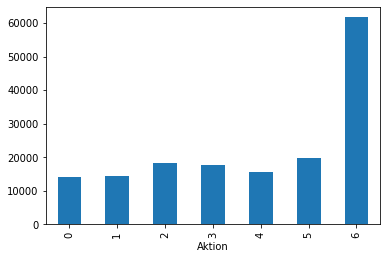

In [6]:
# Plot overall distribution of targets (Aktion)
data.groupby('Aktion').size().plot(kind='bar')

Aktion = 6 might be "Schieben". This might be a problem in one-vs-rest/one-vs-one classificatoin

## One vs. One classification on targets 0 and 1

In [7]:
# select subset of data
target_classes = [0,1]
zeroone = data[data['Aktion'].isin(target_classes)]
zeroone = zeroone.drop(columns='Player')
X = zeroone.loc[:,'H0':'Geschoben']
y = zeroone.loc[:,'Aktion']

# make sure targets are binary (required by GPC implementation of sklearn)
y = y.isin(target_classes[0:1]) # first class = 1, second = 0

In [8]:
# Analyize set. Are there any equal x with other y?
n = (zeroone.groupby(by=list(X.columns)).Aktion.nunique() > 1).sum() / 2
print('Same input but different output: %d (%.2f%%)' % (n, n/X.shape[0]))

Same input but different output: 0 (0.00%)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=1000, random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))

Train: 1000, Test: 27509


In [29]:
kernel = RBF()
clf = GaussianProcessClassifier(kernel, n_restarts_optimizer=5, random_state=23)
%time \
_ = clf.fit(X_train, y_train)

CPU times: user 16.2 s, sys: 4.49 s, total: 20.7 s
Wall time: 10.4 s


In [30]:
%time \
score = clf.score(X_test, y_test)
print('Accuracy: %.3f' % score)

CPU times: user 1.03 s, sys: 180 ms, total: 1.21 s
Wall time: 1.18 s
Accuracy: 0.953


## Multiclass classification: One vs. Rest

In [31]:
# select subset of data
allclasses = data.drop(columns='Player')
X = allclasses.loc[:,'H0':'Geschoben']
y = allclasses.loc[:,'Aktion']

In [32]:
# Analyize set. Are there any equal x with other y?
n = (allclasses.groupby(by=list(X.columns)).Aktion.nunique() > 1).sum() / 2
print('Same input but different output: %d (%.5f%%)' % (n, n/X.shape[0]))

Same input but different output: 24 (0.00015%)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=1000, test_size=5000, random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))

Train: 1000, Test: 5000


In [34]:
%%time
kernel = RBF()
clf = GaussianProcessClassifier(kernel, n_restarts_optimizer=5, random_state=23, multi_class='one_vs_rest')
clf.fit(X_train, y_train)
print('Accuracy: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.595
CPU times: user 53.6 s, sys: 11.3 s, total: 1min 4s
Wall time: 32.8 s


## Multiclass classification (without "Schieben"): One vs. Rest

In [35]:
# select subset of data
allbutschieben = data[data.Aktion != 6]
allbutschieben = allbutschieben.drop(columns='Player')
X = allbutschieben.loc[:,'H0':'Geschoben']
y = allbutschieben.loc[:,'Aktion']

In [36]:
# Analyize set. Are there any equal x with other y?
n = (allbutschieben.groupby(by=list(X.columns)).Aktion.nunique() > 1).sum() / 2
print('Same input but different output: %d (%.5f%%)' % (n, n/X.shape[0]))

Same input but different output: 4 (0.00005%)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=1000, test_size=5000, random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))

Train: 1000, Test: 5000


In [38]:
%%time
kernel = RBF()
clf = GaussianProcessClassifier(kernel, n_restarts_optimizer=5, random_state=23, multi_class='one_vs_rest')
clf.fit(X_train, y_train)
print('Accuracy: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.735
CPU times: user 50.7 s, sys: 8.91 s, total: 59.7 s
Wall time: 30 s


## Multiclass classification (without "Schieben"): One vs. One

In [39]:
%%time
kernel = RBF()
clf = GaussianProcessClassifier(kernel, n_restarts_optimizer=5, random_state=23, multi_class='one_vs_one')
clf.fit(X_train, y_train)
print('Accuracy: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.734
CPU times: user 22.9 s, sys: 5.64 s, total: 28.6 s
Wall time: 14.3 s
